In [16]:
# library
from shapely.geometry import Point
import geopandas as gpd
from shapely import wkt
import geemap
import ee  
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from IPython.display import display 

In [2]:
# ------------------------
# 1. Initialize Earth Engine
# ------------------------
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [3]:
# ------------------------
# 2. Data Preprocessing Functions
# ------------------------
def convert_geometry_column(df):
    """converts WKT geometries to shapely objects."""
    df['geometry'] = df['geometry'].apply(lambda x: wkt.loads(x) if isinstance(x, str) else x)
    return df

def filter_valid_geometries(gdf):
    """filters out invalid or null geometries."""
    gdf = gdf[gdf['geometry'].notnull()]
    gdf = gdf[gdf.is_valid]
    return gdf

In [4]:
# ------------------------
# 3. Model Training Function 
# ------------------------
def train_model(X_train, y_train, task_type):
    """trains a model based on classification or regression."""
    if task_type == "classification":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    model.fit(X_train, y_train)
    return model

In [64]:
# ------------------------
# 4. Model Evaluation Function
# ------------------------
def evaluate_model(model, X_test, y_test, task_type):
    """evaluates model performance using appropriate metrics."""
    y_pred = model.predict(X_test)
    if task_type == "classification":
        score = accuracy_score(y_test, y_pred)
        print(f"Classification Accuracy: {score:.4f}")
    else:
        score = mean_squared_error(y_test, y_pred)
        print(f"Regression MSE: {score:.4f}")
    return score


In [6]:
# ------------------------
# 5. Feature Selection Function
# ------------------------
def get_feature_importance(model, selected_features):
    """retrieves feature importance from trained model."""
    importances = model.feature_importances_
    feature_importance = sorted(zip(selected_features, importances), key=lambda x: x[1], reverse=True)
    print("Feature Importances:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

In [7]:
# ------------------------
# 6. Apply Model to Map
# ------------------------
def apply_model_to_map(model, df, selected_features):
    """applies trained model predictions to dataset and visualizes it on a map."""
    df = convert_geometry_column(df)
    df['prediction'] = model.predict(df[selected_features])
    
    gdf = gpd.GeoDataFrame(df, geometry=df['geometry'], crs='EPSG:4326')
    gdf = gdf.sample(n=250, random_state=42)
    
    try:
        gee_features = geemap.geopandas_to_ee(gdf)
        if gee_features is None:
            print("Error: geemap.geopandas_to_ee() returned None.")
            return None
    except Exception as e:
        print("Error converting GeoDataFrame to EE FeatureCollection:", e)
        return None
    
    Map = geemap.Map()
    Map.addLayer(gee_features, {}, 'Predictions')
    display(Map)
    #return Map

In [65]:
# ------------------------
# 7. Main Execution
# ------------------------
# load dataset
df = pd.read_csv('../notebook_outline_version/data/Costa_Classification_Data_Cleaned2.csv')


# drop duplicate plotIDs, keeping the first occurrence
df = df.drop_duplicates(subset=['plotid'], keep='first')

df = convert_geometry_column(df)

# user selects task type
task_type = input("Choose model type (classification/regression): ")

# define features and target
selected_features = ['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'elevation', 'ndvi']
target = 'Vegetation' if task_type == "classification" else 'Forest_Percentage'

# split data
X = df[selected_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model
model = train_model(X_train, y_train, task_type)

# evaluate model
evaluate_model(model, X_test, y_test, task_type)

# get feature importance
get_feature_importance(model, selected_features)

# apply model to dataset and map results
map_result = apply_model_to_map(model, df, selected_features)
if map_result:
    display(map_result)

Choose model type (classification/regression):  classification


Classification Accuracy: 0.6969
Feature Importances:
RED: 0.1394
SWIR2: 0.1376
GREEN: 0.1348
ndvi: 0.1295
SWIR1: 0.1233
elevation: 0.1231
NIR: 0.1064
BLUE: 0.1058


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [36]:
df['Vegetation'].unique()

array(['Tree', 'Not_Applicable', 'Palms', 'Herbaceas', 'Bush',
       'Another Vegetation', 'Herbaceous', 'Plastico'], dtype=object)

In [38]:
# run model evaluation
model_full = evaluate_model(model, X_test, y_test, task_type)

Classification Accuracy: 0.6969


In [39]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, selected_features):
    importances = model.feature_importances_
    sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh([selected_features[i] for i in sorted_indices], [importances[i] for i in sorted_indices])
    plt.xlabel("Importance Score")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()


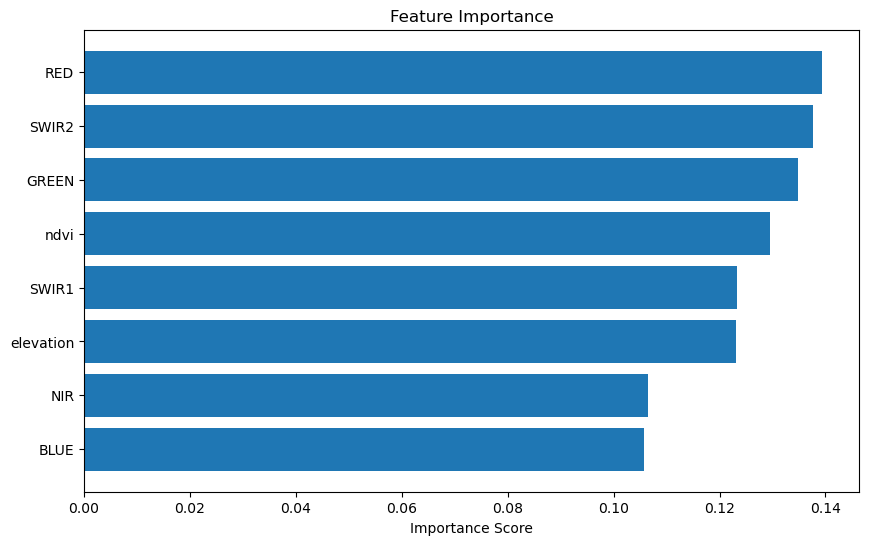

In [40]:
plot_feature_importance(model, selected_features)

In [51]:
# Refined feature list based on importance
top5_features = ['RED', 'SWIR2', 'GREEN', 'ndvi', 'SWIR1']  # Top 5

# Re-run your pipeline with refined_features instead of selected_features

# same target
target = 'Vegetation' if task_type == "classification" else 'Forest_Percentage'

# split data
X = df[selected_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model
acc_top5 = train_model(X_train, y_train, task_type)

# evaluate model
evaluate_model(model, X_test, y_test, task_type)

Classification Accuracy: 0.6969


0.6969292389853138

In [44]:
from sklearn.feature_selection import RFECV

rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFECV(rf, step=1, cv=5, scoring='accuracy')
selector = selector.fit(X_train, y_train)

# Features selected
selected_rfecv = X_train.columns[selector.support_]
print("Optimal features:", selected_rfecv)

Optimal features: Index(['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'elevation', 'ndvi'], dtype='object')


In [ ]:
#'Tree', 'Not_Applicable', 'Palms', 'Herbaceas', 'Bush',
#       'Another Vegetation', 'Herbaceous', 'Plastico'

In [46]:
X_train_refined = X_train[selected_rfecv]
X_test_refined = X_test[selected_rfecv]

acc_rfecv = train_model(X_train_refined, y_train, task_type)
evaluate_model(model_refined, X_test_refined, y_test, task_type)

Classification Accuracy: 0.6969


0.6969292389853138

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test):
    """evaluates the trained model using accuracy, confusion matrix, and classification report."""
    
    # generate predictions
    y_pred = model.predict(X_test)

    # calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)

    # classification report
    cr = classification_report(y_test, y_pred)
    print("\nClassification Report:\n", cr)

    return accuracy, cm, cr

In [55]:
acc_full, cm_full, cr_full = evaluate_model(model_full, X_test, y_test)
acc_top5, cm_top5, cr_top5 = evaluate_model(model_top5, X_test[top5_features], y_test)
acc_rfecv, cm_rfecv, cr_rfecv = evaluate_model(model_rfecv, X_test[selected_rfecv], y_test)

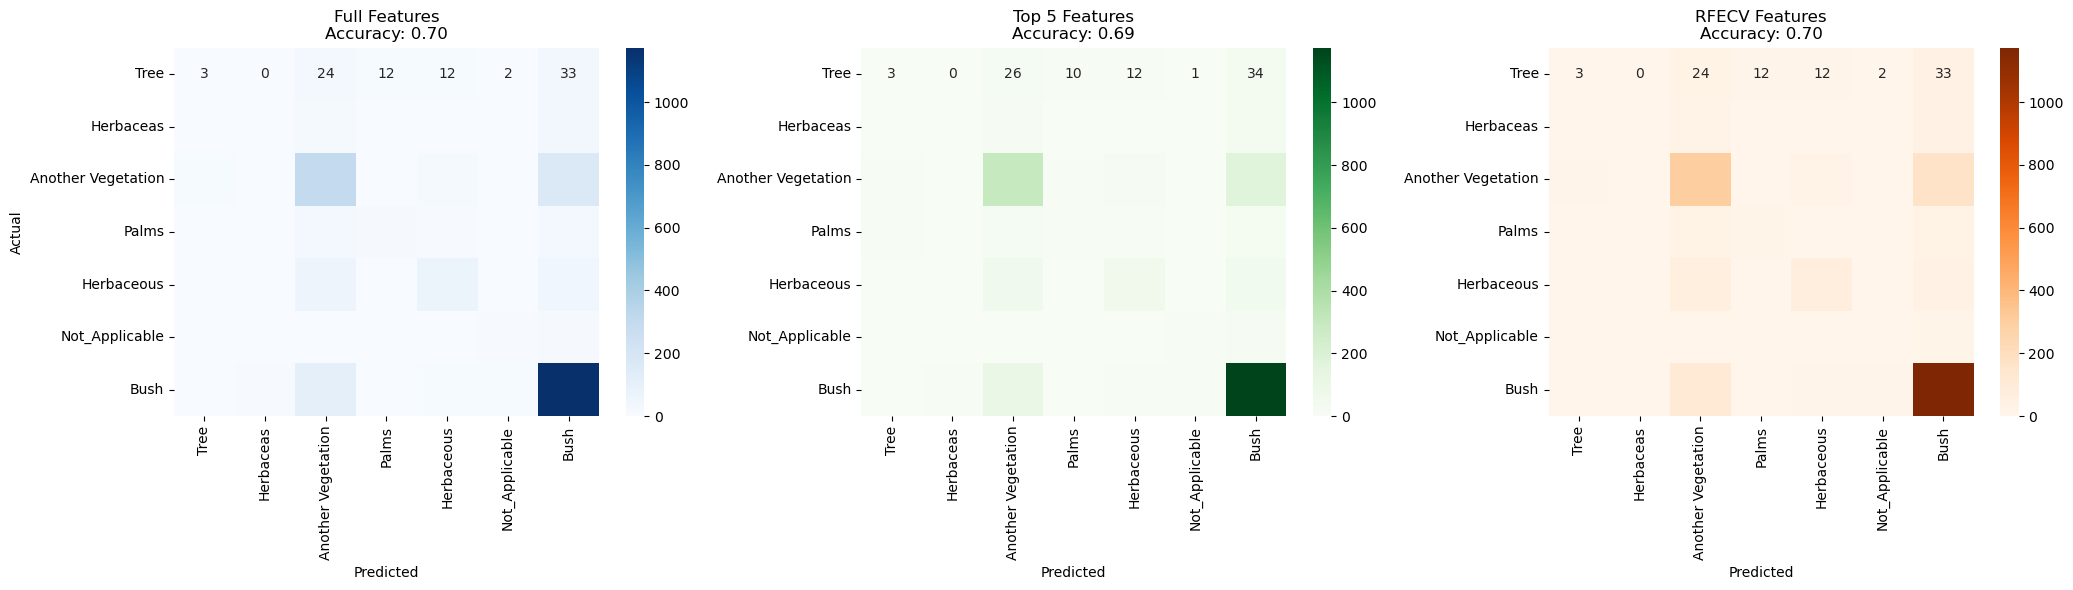

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = y_test.unique().tolist()

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Full Feature Model
sns.heatmap(cm_full, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', ax=axes[0])
axes[0].set_title(f"Full Features\nAccuracy: {acc_full:.2f}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Top 5 Feature Model
sns.heatmap(cm_top5, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Greens', ax=axes[1])
axes[1].set_title(f"Top 5 Features\nAccuracy: {acc_top5:.2f}")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

# RFECV Feature Model
sns.heatmap(cm_rfecv, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Oranges', ax=axes[2])
axes[2].set_title(f"RFECV Features\nAccuracy: {acc_rfecv:.2f}")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


In [57]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Full Features", "Top 5 Features", "RFECV Features"],
    "Accuracy": [acc_full, acc_top5, acc_rfecv],
    "Macro F1": [
        cr_full["macro avg"]["f1-score"],
        cr_top5["macro avg"]["f1-score"],
        cr_rfecv["macro avg"]["f1-score"]
    ],
    "Weighted F1": [
        cr_full["weighted avg"]["f1-score"],
        cr_top5["weighted avg"]["f1-score"],
        cr_rfecv["weighted avg"]["f1-score"]
    ]
})

display(comparison_df.round(3))


,Model,Accuracy,Macro F1,Weighted F1
0,Full Features,0.697,0.358,0.669
1,Top 5 Features,0.691,0.337,0.660
2,RFECV Features,0.697,0.358,0.669


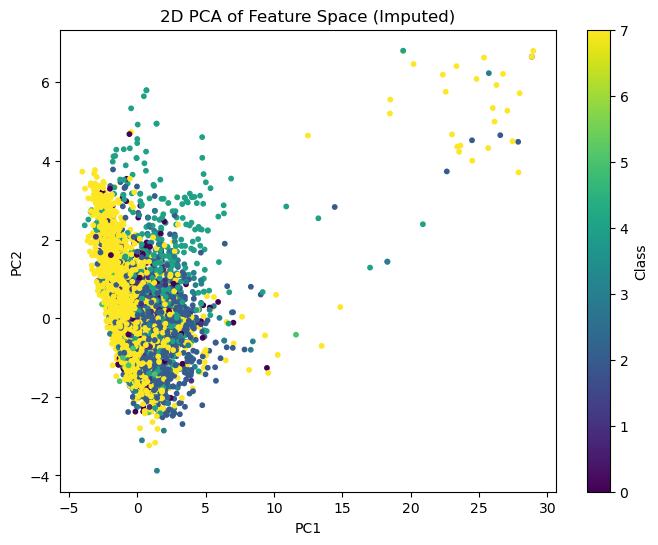

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median', etc.
X_imputed = imputer.fit_transform(X_train[selected_rfecv])
y_imputed = y_train  # unchanged

# Then scale and do PCA
X_scaled = StandardScaler().fit_transform(X_imputed)
X_2d = PCA(n_components=2).fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=y_imputed.astype("category").cat.codes, cmap='viridis', s=10
)
plt.title("2D PCA of Feature Space (Imputed)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Class')
plt.show()


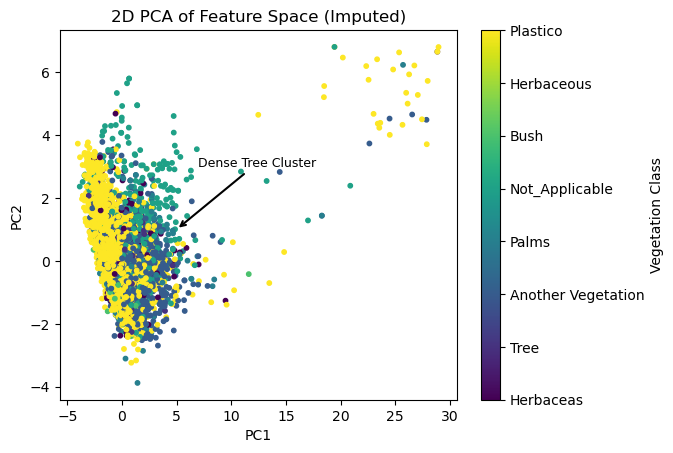

In [69]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# Prepare labels
class_names = y_train.unique().tolist()
class_codes = y_train.astype("category").cat.codes.unique().tolist()

plt.annotate("Dense Tree Cluster", xy=(5, 1), xytext=(7, 3),
             arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=9)

# Scatter
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_imputed.astype("category").cat.codes, cmap='viridis', s=10)
plt.title("2D PCA of Feature Space (Imputed)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Colorbar with labels
cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
cbar.ax.set_yticklabels(class_names)
cbar.set_label("Vegetation Class")

plt.show()

In [72]:
# Get feature loadings for each PC
pca_model = PCA(n_components=2)
pca_model.fit(X_scaled)

components_df = pd.DataFrame(
    pca_model.components_.T,
    columns=['PC1', 'PC2'],
    index=selected_rfecv  # Feature names
)

# Display sorted contributions
print("🔍 Top Contributors to PC1:")
display(components_df['PC1'].sort_values(key=abs, ascending=False))

print("\n🔍 Top Contributors to PC2:")
display(components_df['PC2'].sort_values(key=abs, ascending=False))


🔍 Top Contributors to PC1:


RED          0.438252
GREEN        0.431039
BLUE         0.399464
SWIR2        0.398706
SWIR1        0.374257
ndvi        -0.325640
NIR          0.228180
elevation   -0.073672
Name: PC1, dtype: float64


🔍 Top Contributors to PC2:


elevation    0.582178
NIR         -0.573167
ndvi        -0.333488
SWIR1       -0.330095
BLUE         0.209869
RED          0.209664
GREEN        0.121069
SWIR2       -0.098537
Name: PC2, dtype: float64

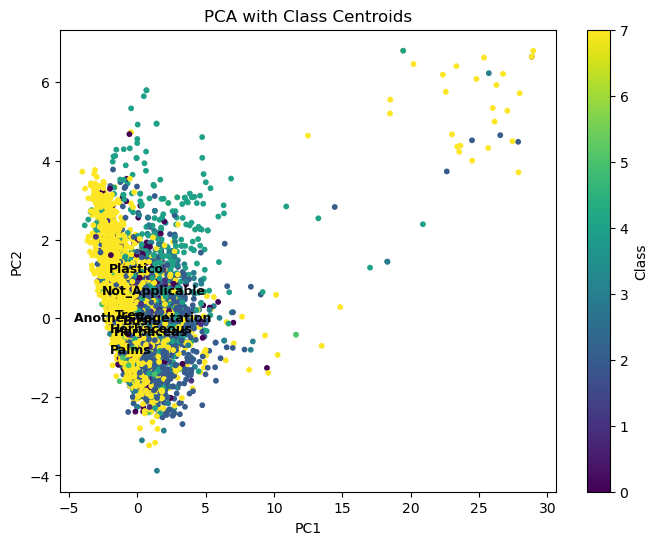

In [73]:
# Create PCA DataFrame
pca_df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
pca_df['Class'] = y_imputed.values

# Compute centroids
centroids = pca_df.groupby('Class')[['PC1', 'PC2']].mean()

# Plot points + centroids
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_imputed.astype("category").cat.codes, cmap='viridis', s=10)

for class_name, row in centroids.iterrows():
    plt.text(row['PC1'], row['PC2'], class_name, fontsize=9, weight='bold', ha='center', va='center', color='black')

plt.title("PCA with Class Centroids")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Class")
plt.show()

In [70]:
!pip install shap

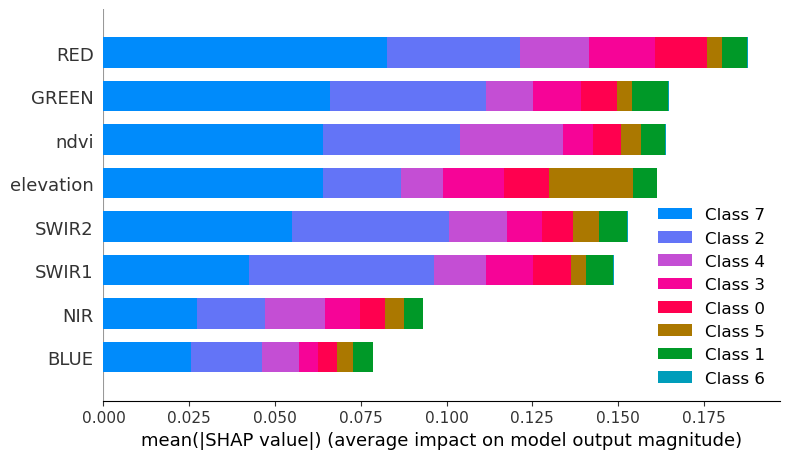

In [71]:
import shap

# Explainer for tree-based models like Random Forest
explainer = shap.TreeExplainer(model_rfecv)
shap_values = explainer.shap_values(X_train[selected_rfecv])

# Global summary plot
shap.summary_plot(shap_values, X_train[selected_rfecv], plot_type="bar")

<Figure size 640x480 with 0 Axes>

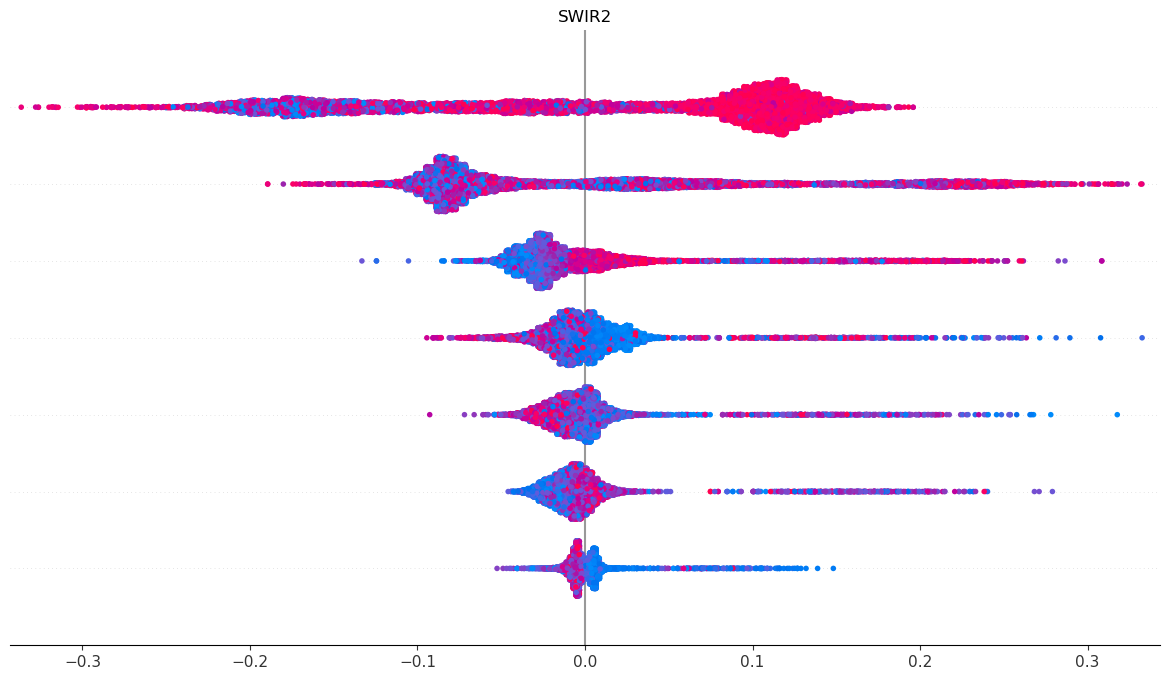

In [74]:
shap.summary_plot(shap_values, X_train[selected_rfecv], class_names=class_names)